In [433]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from mne.decoding import CSP
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import torch
from dataset import EEGDataset
import filter as filter
from mlp import MLP
from plot import plot_eeg, plot_scatter_trials
from model import train_test_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import numpy as np
from sklearn.decomposition import FastICA
import xgboost as xgb
from sklearn.model_selection import train_test_split
import clustering as cl


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [434]:
# Hyper parameters
apply_pca = False   
feature_extraction_method = 'CSP'   # 'ICA' or 'CSP'
apply_normalization = False

# Read Dataset

In [435]:
file_path_1 = "../BCICIV_1_mat/BCICIV_calib_ds1a"
data = EEGDataset(file_path_1, start_window=0.5, end_window=3)

# Preprocessing

## Filters

In [436]:
laplacin_filtered = filter.large_laplacian_filter(data)
bandpass_filterd = filter.bandpass_filter(laplacin_filtered,  l_freq=8, h_freq=40)

Setting up band-pass filter from 8 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 165 samples (1.650 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 11800 out of 11800 | elapsed:    1.9s finished


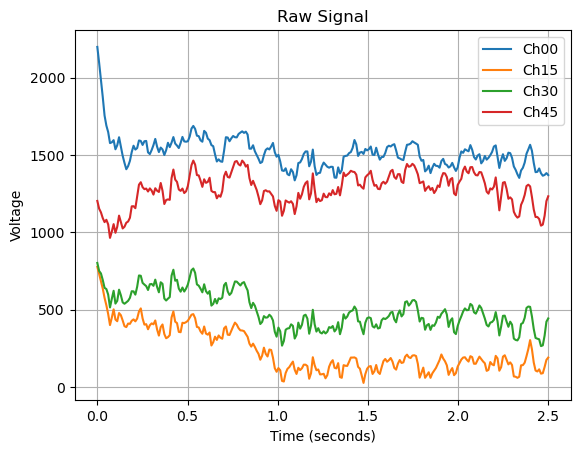

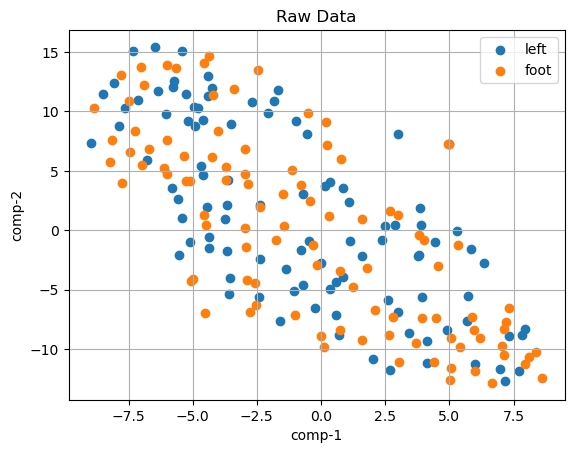

In [437]:
plot_eeg(data, 0, 'Raw Signal')
plt.savefig('../assets/preprocess_raw.png')
plt.show()
plot_scatter_trials(data.trials, data.targets, data.class_labels, 'Raw Data')
plt.savefig('../assets/visual_raw_data.png')

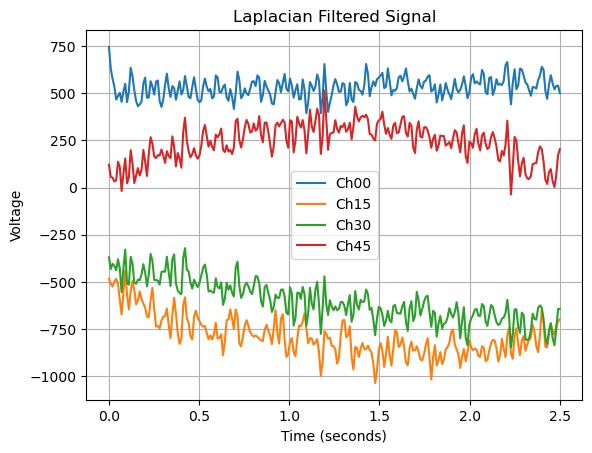

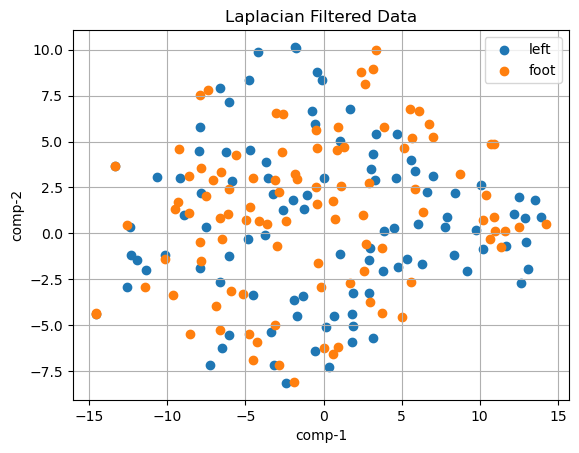

In [438]:
plot_eeg(laplacin_filtered, 0, 'Laplacian Filtered Signal')
plt.savefig('../assets/preprocess_laplacian.png')
plt.show()
plot_scatter_trials(laplacin_filtered.trials, laplacin_filtered.targets, laplacin_filtered.class_labels, 'Laplacian Filtered Data')
plt.savefig('../assets/visual_laplacian_data.png')

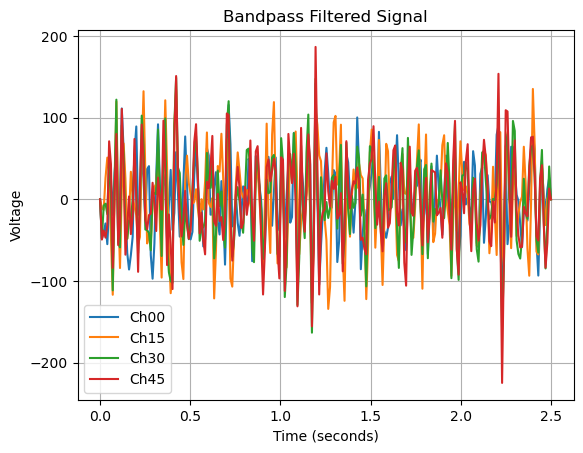

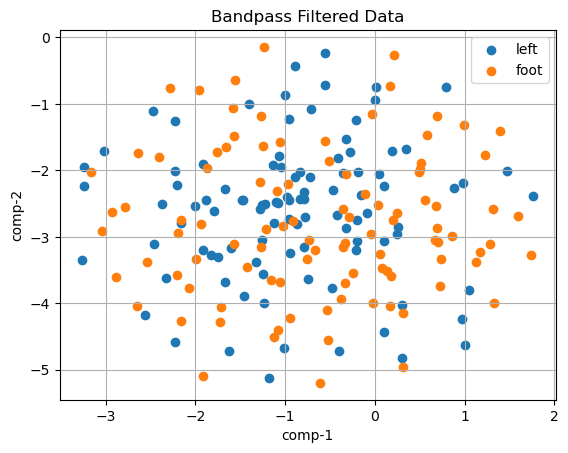

In [439]:
plot_eeg(bandpass_filterd, 0, 'Bandpass Filtered Signal')
plt.savefig('../assets/preprocess_bandpass.png')
plt.show()
plot_scatter_trials(bandpass_filterd.trials, bandpass_filterd.targets, bandpass_filterd.class_labels, 'Bandpass Filtered Data')
plt.savefig('../assets/visual_bandpass_data.png')

In [440]:
data = bandpass_filterd

## Train Test Split

In [441]:
X = data.trials
y = data.targets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.25, 
    random_state=40,
    stratify=y
)

## PCA

In [442]:
pca = PCA(n_components=X_train.shape[0])
X_train_pca = pca.fit_transform(X_train.reshape(X_train.shape[0], -1))
X_test_pca = pca.transform(X_test.reshape(X_test.shape[0], -1))

In [443]:
if apply_pca:
    X_train = X_train_pca.reshape(X_train.shape[0], X_train.shape[0] // 2, 2)
    X_test = X_test_pca.reshape(X_test.shape[0], X_train.shape[0] // 2, 2)

## ICA

In [444]:
ica = FastICA(n_components=59,
              random_state=42)

X_train_ica = ica.fit_transform(X_train.reshape(X_train.shape[0], -1), y_train)

X_test_ica = ica.transform(X_test.reshape(X_test.shape[0], -1))


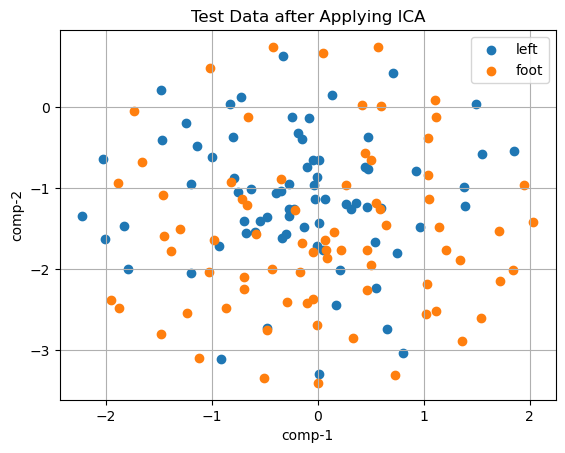

In [445]:
plot_scatter_trials(X_train_ica, y_train, data.class_labels, 'Test Data after Applying ICA')
plt.savefig('../assets/train_data_ica.png') 

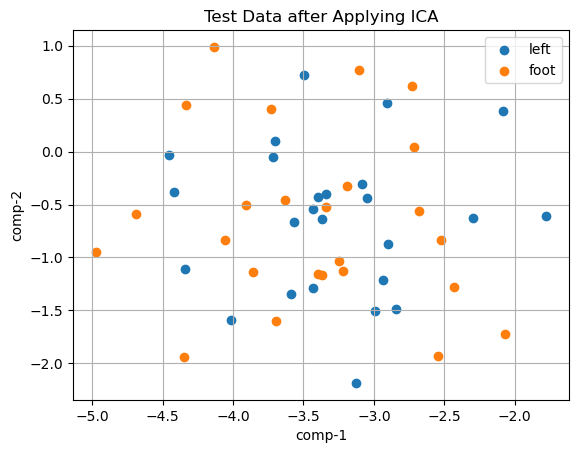

In [446]:
plot_scatter_trials(X_test_ica, y_test, data.class_labels, 'Test Data after Applying ICA')
plt.savefig('../assets/test_data_ica.png') 

## CSP

In [447]:
csp = CSP(n_components=59, reg=None, log=None, norm_trace=False)
X_train_csp = csp.fit_transform(X_train, y_train)
X_test_csp = csp.transform(X_test)

Computing rank from data with rank=None


    Using tolerance 1.1e+03 (2.2e-16 eps * 59 dim * 8.4e+16  max singular value)
    Estimated rank (data): 59
    data: rank 59 computed from 59 data channels with 0 projectors
Reducing data rank from 59 -> 59
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


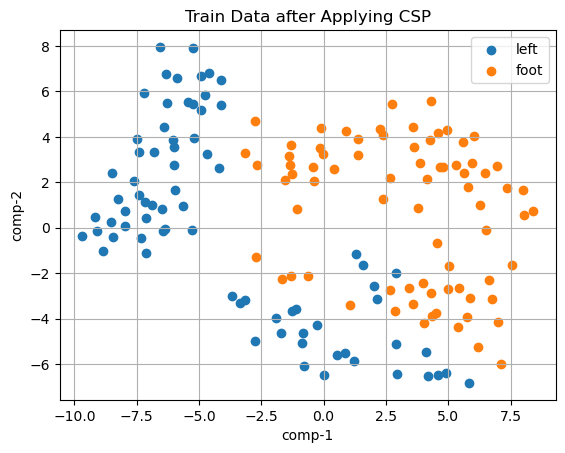

In [448]:
plot_scatter_trials(X_train_csp, y_train, data.class_labels, 'Train Data after Applying CSP')
plt.savefig('../assets/train_data_csp.png')

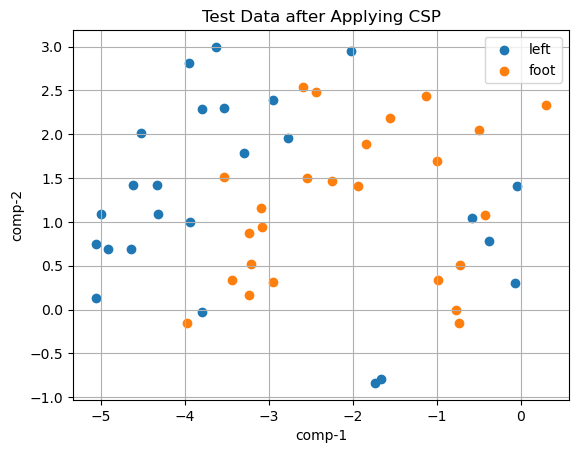

In [449]:
plot_scatter_trials(X_test_csp, y_test, data.class_labels, 'Test Data after Applying CSP')
plt.savefig('../assets/test_data_csp.png') 

In [450]:
if feature_extraction_method == 'ICA':
    X_train = X_train_ica
    X_test = X_test_ica
else:
    X_train = X_train_csp
    X_test = X_test_csp

In [451]:
def normalize(X):
    X_mean = np.mean(X, axis=0)
    X_std_dev = np.std(X, axis=0)
    X_normalized = (X - X_mean) / X_std_dev
    return X_normalized

if apply_normalization:
    X_train = normalize(X_train)
    X_test = normalize(X_test)  

## Logistic Regression

              precision    recall  f1-score   support

        left       0.84      0.84      0.84        25
        foot       0.84      0.84      0.84        25

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.84      0.84      0.84        50



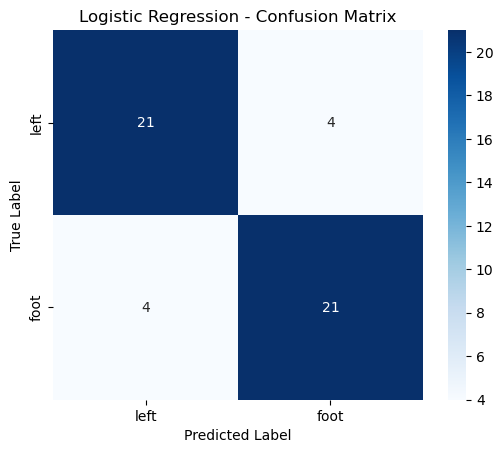

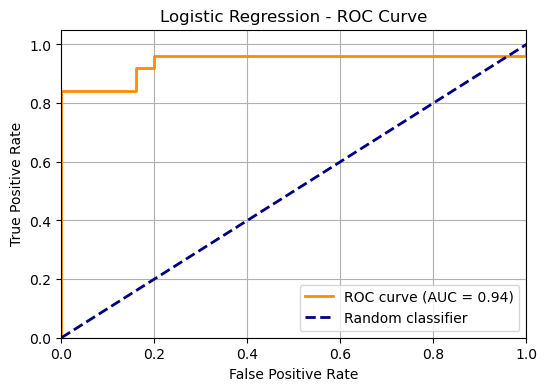

In [452]:
model = LogisticRegression(max_iter=300)
train_test_report(model, X_train, X_test, y_train, y_test, data.class_labels, 'Logistic Regression')

## SVM

              precision    recall  f1-score   support

        left       0.84      0.84      0.84        25
        foot       0.84      0.84      0.84        25

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.84      0.84      0.84        50



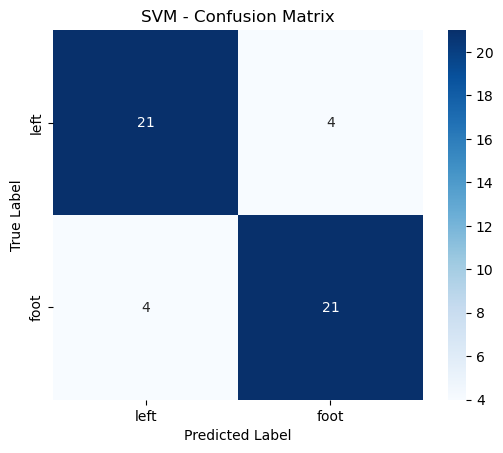

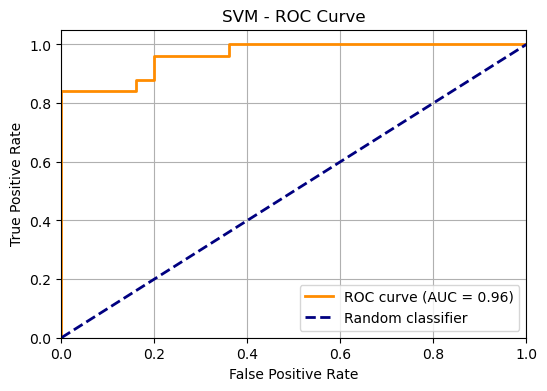

In [453]:
model = SVC(kernel='rbf', C=1, probability=True)
train_test_report(model, X_train, X_test, y_train, y_test, data.class_labels, 'SVM')

## KNN

              precision    recall  f1-score   support

        left       0.91      0.80      0.85        25
        foot       0.82      0.92      0.87        25

    accuracy                           0.86        50
   macro avg       0.87      0.86      0.86        50
weighted avg       0.87      0.86      0.86        50



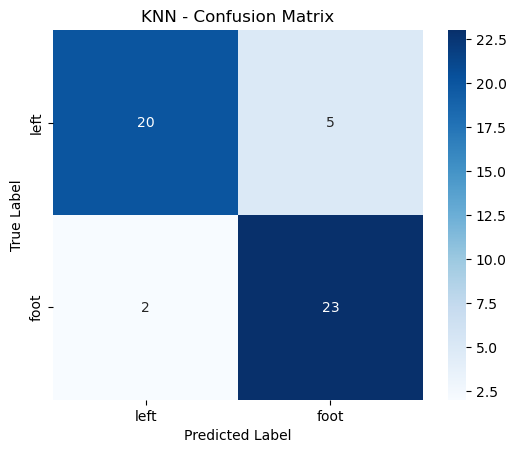

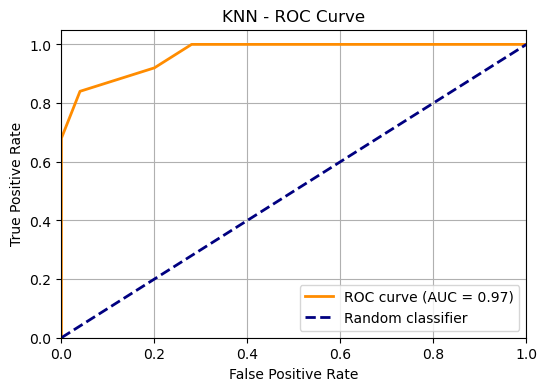

In [454]:
model = KNeighborsClassifier(n_neighbors=7)
train_test_report(model, X_train, X_test, y_train, y_test, data.class_labels, 'KNN')

## MLP

Epoch [50/400], Loss: 0.5070
Epoch [100/400], Loss: 0.3397
Epoch [150/400], Loss: 0.3221
Epoch [200/400], Loss: 0.3467
Epoch [250/400], Loss: 0.3229
Epoch [300/400], Loss: 0.3166
Epoch [350/400], Loss: 0.3143
Epoch [400/400], Loss: 0.3156

              precision    recall  f1-score   support

        left       0.86      0.76      0.81        25
        foot       0.79      0.88      0.83        25

    accuracy                           0.82        50
   macro avg       0.82      0.82      0.82        50
weighted avg       0.82      0.82      0.82        50



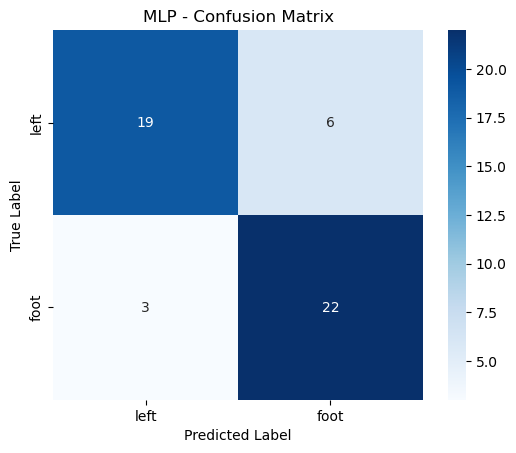

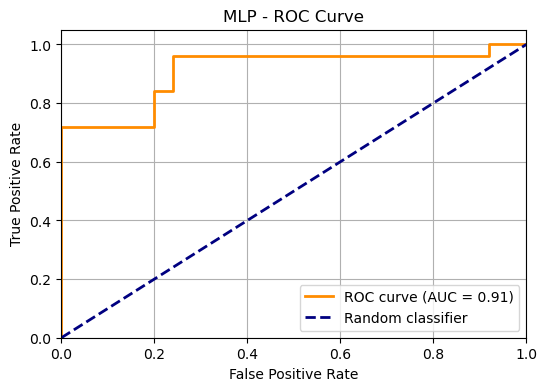

In [455]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MLP(input_shape=(-1, 59),
            num_classes=2, 
            batch_size=64,
            lr=0.001,
            num_epochs=400, 
            device=device
        ).to(device)

train_test_report(model, X_train, X_test, y_train, y_test, data.class_labels, 'MLP')

## AdaBoost

              precision    recall  f1-score   support

        left       0.91      0.84      0.87        25
        foot       0.85      0.92      0.88        25

    accuracy                           0.88        50
   macro avg       0.88      0.88      0.88        50
weighted avg       0.88      0.88      0.88        50



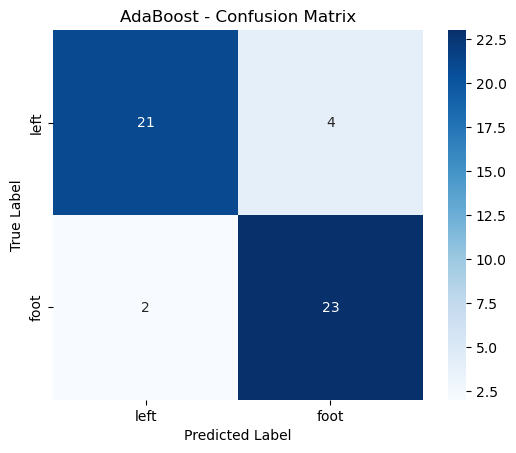

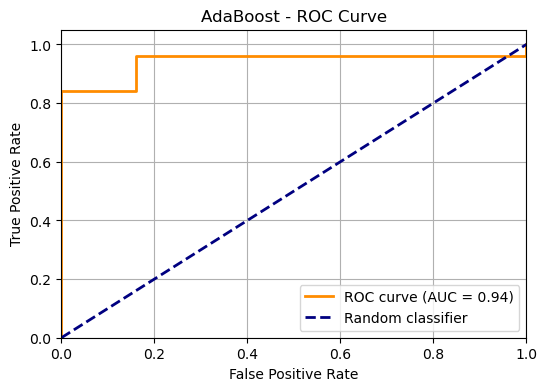

In [456]:
estimator = LogisticRegression(max_iter=300, C=10)
model = AdaBoostClassifier(
    estimator=estimator, 
    n_estimators=10, 
    random_state=42)

train_test_report(model, X_train, X_test, y_train, y_test, data.class_labels, 'AdaBoost')

## XGBoost

              precision    recall  f1-score   support

        left       0.96      0.88      0.92        25
        foot       0.89      0.96      0.92        25

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50



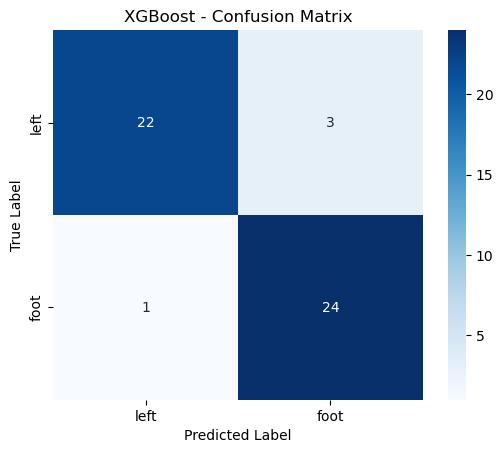

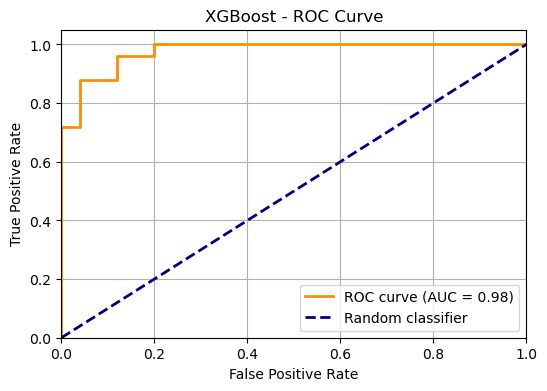

In [457]:
model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=2,
    max_depth=1,
    learning_rate=0.1,
    n_estimators=200,
    random_state=42,
    reg_alpha=2,  
)

train_test_report(model, X_train, X_test, y_train, y_test, data.class_labels, 'XGBoost')

# Clustering

In [458]:
clustering_X = np.concatenate([X_train_csp, X_test_csp])
Y = np.concatenate([y_train, y_test])
pca = PCA(n_components=2)
X = pca.fit_transform(clustering_X)
scalar = MinMaxScaler()
X = scalar.fit_transform(X)

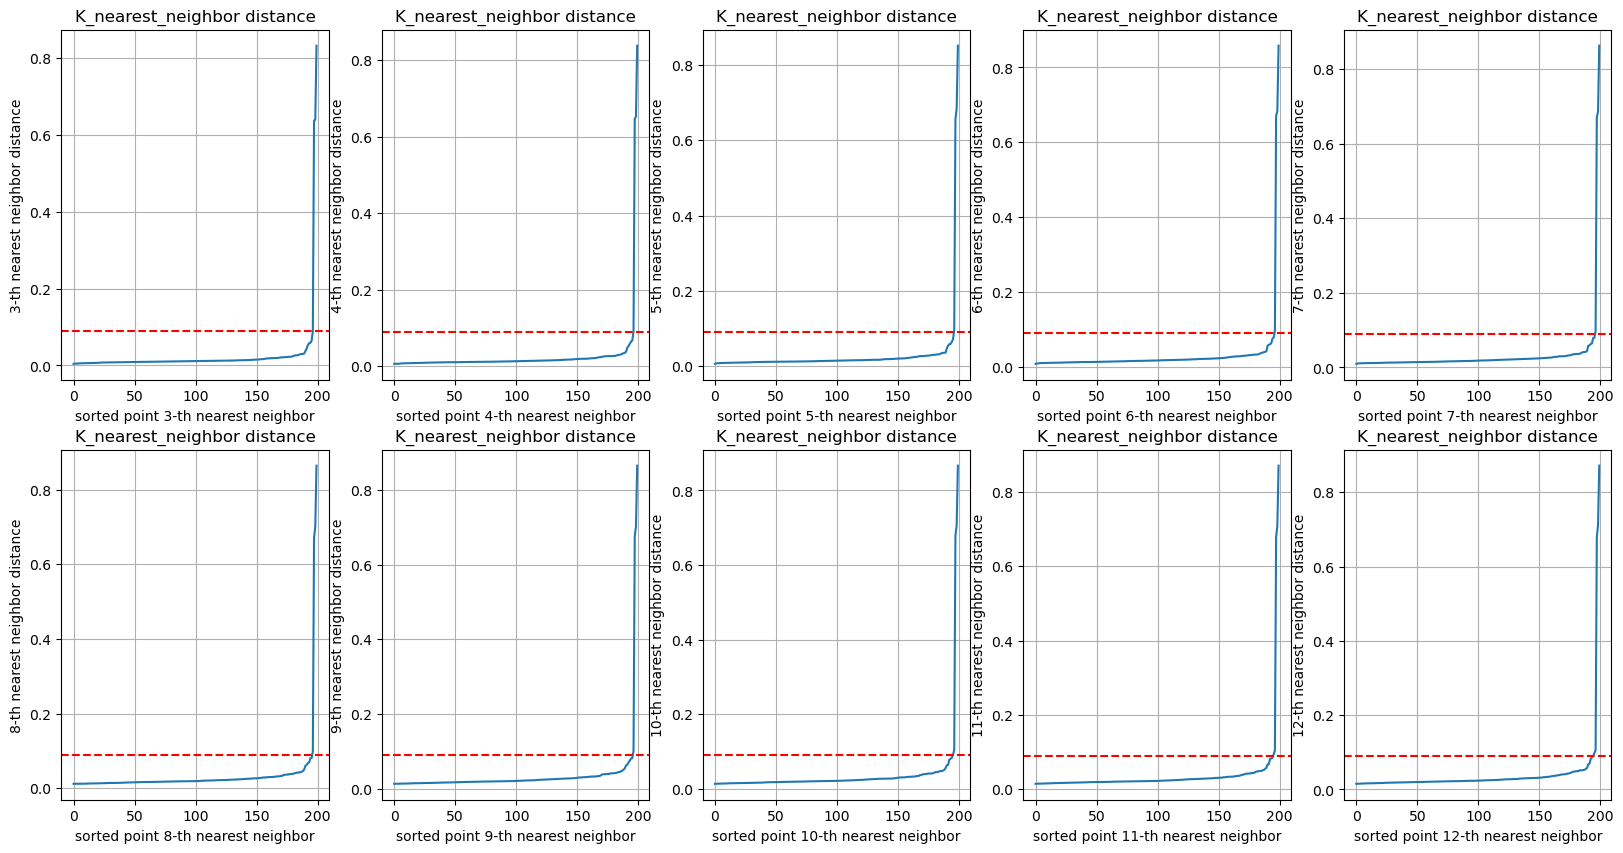

In [459]:
plt.figure(figsize=(20, 10))
for i, k in enumerate(range(3, 13)):
    plt.subplot(2, 5, i+1)
    cl.plot_K_nearest_neighbor_distance(X=X, K=k)

plt.show()

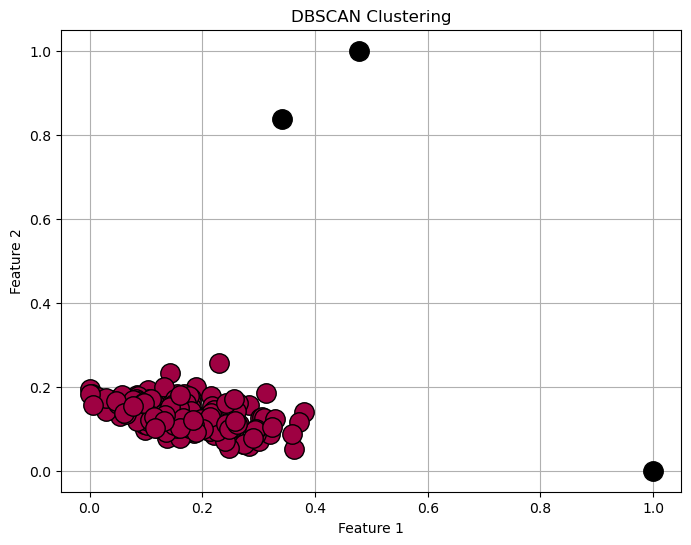

silhouette_score:  0.8602715817212311
homogeneity_score:  0.0012438708805110634


In [469]:
cl.apply_DB_scan_clustering(eps=0.09, min_samples=3, X=X, y=Y)

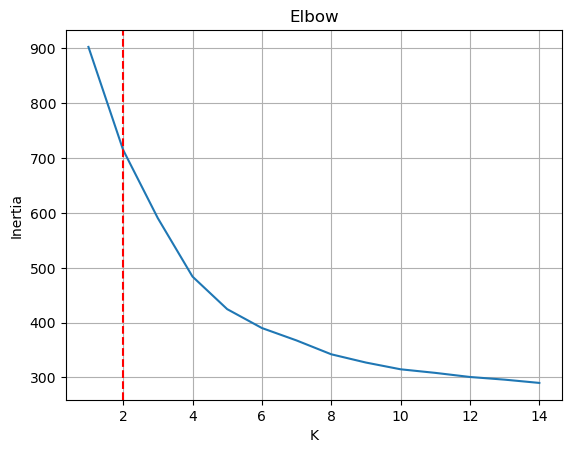

In [467]:
cl.plot_kmeans_elbow(X=clustering_X)

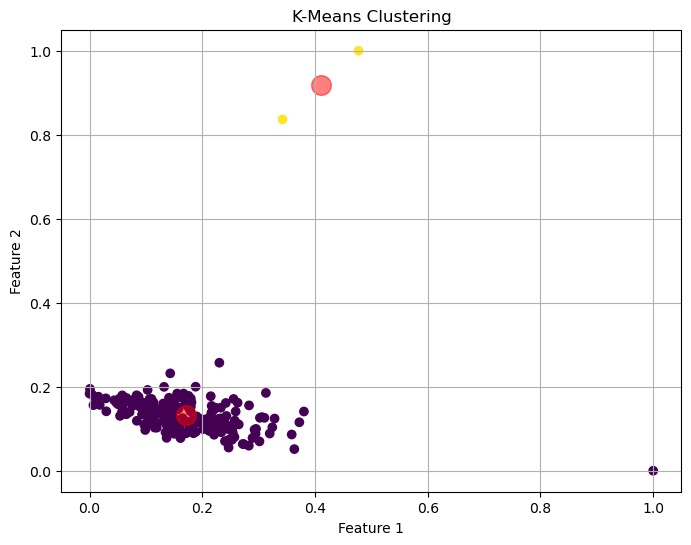

silhouette_score :  0.8629590389456142
homogeneity_score :  0.0


In [465]:
cl.apply_kmeans_clustering(X=X, y=Y, k=2)

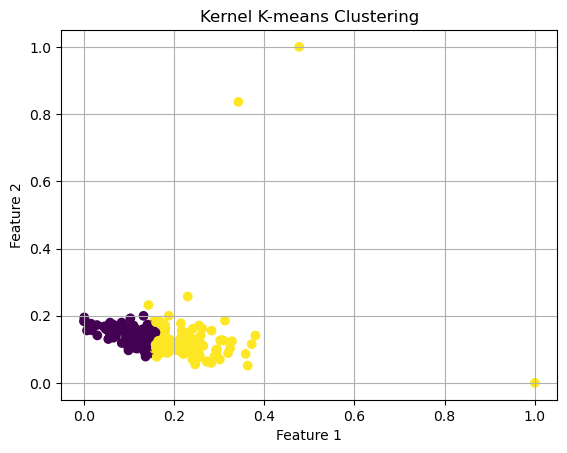

silhouette_score :  0.41092256744251515
omogeneity_score :  0.11300728737288131


In [463]:
cl.apply_kernel_kmeans_clustering(X=X, y=Y, k=2)